# PROJET OPTIMISATION

## Contexte

Les systèmes de partage de vélos enregistrent durée, départ et arrivée, transformant ces données en capteurs virtuels de mobilité urbaine, exploitables pour prédire le trafic et la demande de vélos. Nous nous intéressons ici au nombre de vélos loués par jours en fonction des données climatiques sur un grand échantillon disponible dans la base de données : bike_sharing_275.

Parmi les nombreuses variables disponibles, nous ne considérons que les suivantes :

-$X^{[1]}$ **mnth** : le mois de l'année, codé de 1 à 12 et normalisé dans $[0,1]$ en divisant par 12 ;

-$X^{[2]}$ **weathersit** : les conditions météorologiques, codées comme suit :
    
    * 0.25 : clair, quelques nuages, partiellement nuageux
    
    * 0.5  : nuageux + brume, nuages fragmentés, brume
    
    * 0.75 : neige légère, petite pluie + orage + nuages épars, petite pluie + nuages épars
    
    * 1    : forte pluie + grêle + orage + brume, neige + brouillard
    
-$X^{[3]}$ **temp** : température en Celsius, normalisée par $\dfrac{t - t_{\min}}{t_{\max} - t_{\min}}$, avec $t_{\min} = -8$ et $t_{\max} = 39$ ;

-$X^{[4]}$ **atemp** : température ressentie en Celsius, normalisée par $\dfrac{t - t_{\min}}{t_{\max} - t_{\min}}$, avec $t_{\min} = -16$ et $t_{\max} = 50$ ;

-$X^{[5]}$ **hum** : taux d'humidité dans l'air, déjà dans $[0,1]$ ;

-$X^{[6]}$ **windspeed** : vitesse du vent en mph, divisée par la valeur maximale 67 pour normaliser.

Toutes les données considérées sont donc à valeur dans le segment $[0,1]$.

Nous cherchons à modéliser la relation entre ces conditions climatiques et le nombre de vélos loués, c'est-à-dire à estimer une fonction 
$$
Y = f(X), \quad X = (X^{[1]}, \ldots, X^{[6]}).
$$
Nous ferons l'hypothèse d'un modèle de régression linéaire : nous supposons que le nombre de vélos loués $Y$ peut s'écrire comme une combinaison linéaire des features météorologiques $X = (X^{[1]}, \ldots, X^{[6]})$ :
$$
Y \approx \tilde{X}  \beta + \varepsilon
$$
où $\tilde{X} = \begin{pmatrix}
1 & X^{[1]}_{1} & \dots & X^{[6]}_{1} \\
1 & X^{[1]}_{2} & \dots & X^{[6]}_{2} \\
\vdots & \vdots & \ddots & \vdots \\
1& X^{[1]}_{731}& \dots & X^{[6]}_{731}
\end{pmatrix} \in \mathcal{M}_{731,7}(\mathbb{R})$  et $\beta = \begin{pmatrix}
    \beta_0 \\ \vdots \\ \beta_6 
\end{pmatrix} \in \mathbb{R}^7$ est le vecteur des coefficients à estimer et $\varepsilon$ est le terme d'erreur.
L'objectif est donc d'estimer $\beta$ comme minimum d'une certaine fonction de coût.

In [2]:
#Import des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import cho_factor, cho_solve
import time
import ast

#Import des données et sélection des features qui nous interresse
df = pd.read_csv("day.csv")
colonnes_features = ["mnth","weathersit","temp", "atemp", "hum","windspeed"]
X = df[colonnes_features].to_numpy()
Y = df[["cnt"]].to_numpy()
Xtilde = np.hstack((np.ones((731, 1)), X))
Xtilde[:,0] = Xtilde[:,0]/12 
Xtilde[:,1] = Xtilde[:,1]/4 

## Problème de Minimisation
L'objectif de ce projet est d'obtenir les coefficients de $\hat{\beta}$ qui est le plus proche de $\beta$.

Le problème de minimisation considéré est de la forme:
$$
\min_{\beta\in \mathbb{R}^7} \frac{1}{2}\|Y-\tilde X\beta\|_2^2 + \lambda \| \beta \|_1
$$
où $\lambda>0$ est un hyper-paramètre de régularisation.

Le problème peux se réécrire comme :
$$\hat{\beta}_{\lambda}=\arg \min_{\beta \in \mathbb{R}^7} f_1(\beta) + f_2(\beta)$$

avec $f_1(\beta) =  \frac{1}{2}\|Y-\tilde X\beta\|_2^2$ et $f_2(\beta) = \lambda \| \beta \|_1$.


### Caractère bien posé du problème

In [3]:
print("On a que notre matrice est de rang maximale puisque son rang est :", np.linalg.matrix_rank(Xtilde))

On a que notre matrice est de rang maximale puisque son rang est : 7


Il suffit de montrer que $f$ est continue coercive et strictement convexe. 

**Coercivité**

Montrons que $f$ est une fonction coercive. Pour $\beta \in \mathbb{R}^7$, on peut écrire :
$$
f_1(\beta) = \dfrac{1}{2} \Vert Y\Vert^2+ \dfrac{1}{2} \langle \tilde{X}^T \tilde{X} \beta , \beta \rangle - \langle Y,\tilde{X} \beta \rangle
$$
Mais, puisque $\tilde{X}$ est de rang maximale, $\tilde{X}^T \tilde{X} \in S^{++}_{n}(\mathbb{R})$, notons $\lambda_0>0$ la plus petite valeur propre et $(e_0,\ldots,e_6)$ une base orthonormée de vecteurs propres.

\begin{align*}
    \langle \tilde{X}^T \tilde{X} \beta , \beta \rangle &= \langle \tilde{X}^T \tilde{X} \left( \sum_{i=0}^{6}\beta_i e_i \right) ,  \sum_{j=0}^{6}\beta_j e_j  \rangle \\ &=  \sum_{i=0}^{6}  \sum_{j=0}^{6} \beta_i \beta_j \langle \tilde{X}^T \tilde{X}  e_i,e_j \rangle \\ &= \sum_{i=0}^{6}  \sum_{j=0}^{6} \beta_i \beta_j \langle \lambda_i  e_i,e_j \rangle \\ &=\sum_{i=0}^{6} \beta_i^2 \lambda_i \\ &\geq \lambda_0 \Vert \beta \Vert_2^2
\end{align*}

Alors, par équivalence des normes en dimension finie, il existe $K>0$ tq :
$$
f(\beta) \geq \dfrac{1}{2} \Vert Y\Vert^2+\lambda_0 \Vert \beta \Vert_2^2 - \Vert \tilde{X}^TY\Vert \Vert \beta\Vert_2 + \lambda K \Vert \beta \Vert_2
$$
Ce qui donne bien $f(\beta) \underset{\Vert \beta \Vert \to +\infty}{\longrightarrow} +\infty$

**Stricte convexité**

D'abord $f_2$ est une fonction convexe comme somme de fonctions convexes.
Montrons que $f_1$ est une fonction strictement convexe. Pour $h\in \mathbb{R}^7$:
\begin{align*}
    f_1(\beta+h) &= \dfrac{1}{2} \Vert Y - \tilde{X}(\beta+h)\Vert_2^2  =  \dfrac{1}{2} \Vert Y - \tilde{X}\beta - \tilde{X}h)\Vert_2^2 \\ &= \dfrac{1}{2} \Vert Y - \tilde{X}\beta \Vert_2^2 +\dfrac{1}{2} \Vert\tilde{X}h\Vert_2^2 - \langle  Y - \tilde{X}\beta ,\tilde{X}h \rangle \\ &= f_1(\beta) - \langle \tilde{X}^T(Y - \tilde{X}\beta) ,h \rangle +R(h)
\end{align*}
D'où $f_1$ est différentiable et $\nabla f_1(\beta)= -\tilde{X}^T(Y - \tilde{X}\beta) $ et $Hess_{f_1}(\beta) = \tilde{X}^T\tilde{X} \in S_{n}^{++}(\mathbb{R})$ d'où la stricte convexité.
Ainsi, la fonction $f$ est strictement convexe comme somme d'une fonction strictement convexe et d'une fonction convexe.

**Bilan**

$f$ est continue, coercive et strictement convexe donc le problème d'estimation Lasso est bien posé, puisque $f$ admet un unique minumum sur $\mathbb{R}^7$.

### Fonctions utiles

In [4]:
def loss_numpy(beta):
    MSE = np.linalg.norm(Y - Xtilde@beta)**2
    L1 = np.sum(np.abs(beta))
    return .5*MSE + lmb*L1

def prox_l1(lmb, tau, beta):
    """ Renvoie le prox pour la norme L1
    Paramètres
    ----------
    gamma: float
        Pas de descente
    lambd: float
        Paramètre de régularisation
    beta: numpy.ndarray
        Point d'évaluation
        
    Returns
    -------
    y: numpy.ndarray
        Point of argmin
    """
    return np.sign(beta) * np.maximum(np.abs(beta) - lmb*tau, 0.0)

def grad_f1(beta, Xtilde, Y):
    """Renvoie le gradient de la fonction f_1 = || Y- Xtilde beta||^2
    Paramètres
    ----------
    beta: numpy.ndarray
        Point d'évaluation
    Xtilde: numpy.ndarray
        Features de la database
    Y: numpy.ndarray
        Variable cnt dans notre database
    Return
    ------
    y: numpy.ndarray
        Gradient de f_1(beta)
    """
    return ((-Xtilde.T)@(Y-Xtilde@beta))


def prox_f1(beta, tau, Xtilde, Y):
    """Renvoie le prox de la fonction tau*f_1 = tau*0.5*|| Y- Xtilde beta||^2
    Paramètres
    ----------
    beta: numpy.ndarray
        Point d'évaluation
    tau: float
        pas de descente
    Xtilde: numpy.ndarray
        Features de la database
    Y: numpy.ndarray
        Variable cnt dans notre database
    Return
    ------
    y: numpy.ndarray
        Gradient de f_1(beta)
    """
    n_features = Xtilde.shape[1]
    A = Xtilde.T @ Xtilde*tau + np.eye(n_features)
    B = Xtilde.T @ Y *tau + beta

    # Résolution stable via Cholesky
    c, lower = cho_factor(A)
    x = cho_solve((c, lower), B)
    return x

# SECTION 1 : Algorithme FISTA

Pour résoudre notre problème de minimisation, on peut implémanter l'algorithme FISTA. 
En effet, $f_1$ et $f_2$ sont dans $\Gamma_0(\mathbb{R}^7)$ et $f_1$ est différentiable avec $\nabla f_1$ qui est $\|\tilde X\|_2^2$  Lipschitzien.

**Itérations**

Soient $\tau \in ]0,2/ \Vert \tilde{X} \Vert^2[$ et $a > 2$, alors:
\begin{align}
(\forall k \in \mathbb{N}) \qquad 
x_{k + 1} &= \operatorname{prox}_{\tau f_2}\left(v_k - \tau \nabla f_1(v_k)\right) \textrm{,}\\
t_{k} & = \frac{k+a-1}{a} \textrm{,}\\
\alpha_k &= \frac{t_k - 1}{t_{k+1}} \textrm{,}\\
v_{k+1} &= x_{k+1} + \alpha_k (x_{k+1} - x_k) \textrm{.}
\end{align}
La suite $(x_k)_{k \in \mathbb{N}}$ converge vers un minimiseur de $f_1 + f_2$.

**Remarque:** On travaillera toujours avec $a = 4$.

In [5]:
def algoFISTA(x0, Y, Xtilde, tau, max_iter, lmb=0.0, tol=1e-5, a=4.0):
    """
    Algorithme FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)

    Paramètres
    ----------
    x0 : np.ndarray
        État initial du vecteur de paramètres.
    Y : np.ndarray
        Données observées (ex. : comptage de vélos).
    Xtilde : np.ndarray
        Matrice de données.
    tau : float
        Pas de descente.
    max_iter : int
        Nombre maximal d’itérations autorisé.
    lmb : float, optionnel
        Paramètre de régularisation L1 (par défaut 0.0).
    tol : float, optionnel
        Tolérance de convergence : l’algorithme s’arrête si 
        ||x_{n+1} - x_n|| < tol (par défaut 1e-5).
    a : float, optionnel
        Paramètre du schéma FISTA (par défaut 4.0).

    Retours
    -------
    xn : np.ndarray
        Tableau des itérés successifs (forme : [n_iter + 1, K]).
        Le dernier élément est une approximation du minimum.
    err : np.ndarray
        Suite des erreurs entre itérations successives.
    niter : int
        Nombre d’itérations réellement effectuées avant arrêt.
    """

    #Initialisation
    niter = 0
    xn = [x0]
    vn = [x0]
    err = []

    #Pré-calcul des coefficients FISTA
    t = (1 / a) * np.arange(max_iter) + (1 - 1 / a)
    alpha = (t[:-1] - 1) / t[1:]

    #Première itération
    grad = grad_f1(x0, Xtilde, Y)
    x1 = prox_l1(lmb, tau, x0 - tau * grad)
    v1 = x1 + alpha[0] * (x1 - x0)

    xn.append(x1)
    vn.append(v1)
    err.append(np.linalg.norm(x1 - x0))

    #Boucle principale
    while (err[-1] > tol) and (niter + 2 < max_iter):
        # Vérification de stabilité numérique
        if (np.any(np.isnan(xn[-1]))) or (np.any(np.isinf(xn[-1]))) or (np.linalg.norm(xn[-1]) > 1e50):
            #print(f"Valeurs instables détectées à l'itération {niter}, arrêt prématuré.")
            niter = max_iter
            break
        niter += 1
        grad = grad_f1(vn[-1], Xtilde, Y)
        x_next = prox_l1(lmb, tau, vn[-1] - tau * grad)
        diff = np.linalg.norm(x_next - xn[-1])
        v_next = x_next + alpha[niter] * (x_next - xn[-1])
        
        err.append(diff)
        xn.append(x_next)
        vn.append(v_next)

    return np.array(xn), np.array(err), niter

In [6]:
#Paramètres généraux
x0 = np.zeros((7,1))
tau = 10**(-5)
lmb = np.sqrt(np.log(6)/732)
max_iter = 20_000
tol = 1e-5

## 1) Visualisation de la fonction objectif

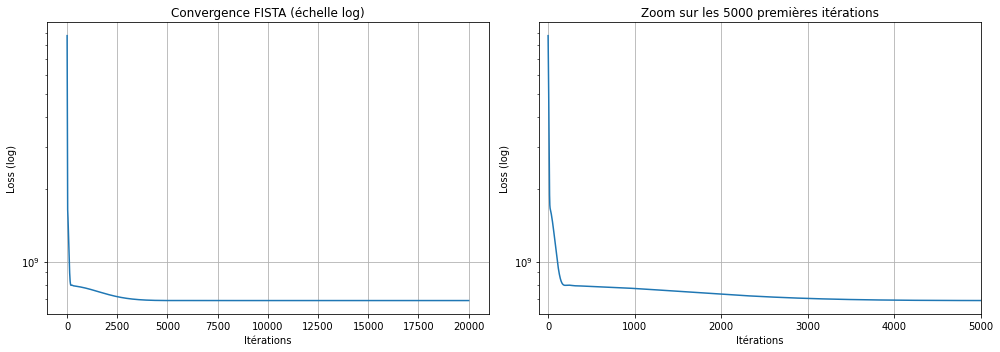

Une valeur minimale de notre loss vaut : 686913635.348753


In [7]:
xn,_,_ = algoFISTA(x0, Y, Xtilde, tau, max_iter, lmb, tol, a=4.0)
loss = [loss_numpy(beta) for beta in xn]
niter = np.linspace(1,max_iter,max_iter)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Graphe global
ax[0].plot(niter, loss)
ax[0].set_yscale("log")
ax[0].set_xlabel("Itérations")
ax[0].set_ylabel("Loss (log)")
ax[0].set_title("Convergence FISTA (échelle log)")
ax[0].grid(True)

#Zoom
ax[1].plot(niter, loss)
ax[1].set_yscale("log")
ax[1].set_xlim(-100, 5000)
ax[1].set_xlabel("Itérations")
ax[1].set_ylabel("Loss (log)")
ax[1].set_title("Zoom sur les 5000 premières itérations")
ax[1].grid(True)

plt.tight_layout()
plt.show()

print("Une valeur minimale de notre loss vaut :", loss[-1])

## 2) Convergence de l'argmin composante par composante

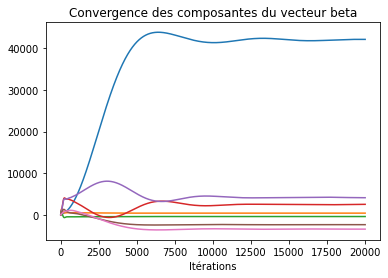

In [8]:
plt.figure()
for i in range(7):
    plt.plot(range(0,len(xn)),xn[:,i])
plt.title("Convergence des composantes du vecteur beta")
plt.xlabel("Itérations")
plt.show()

## 3) Recherche du meilleur pas algorithmiquement

Le paramètre tau qui minimise le temps de sortie est : 0.0002979798


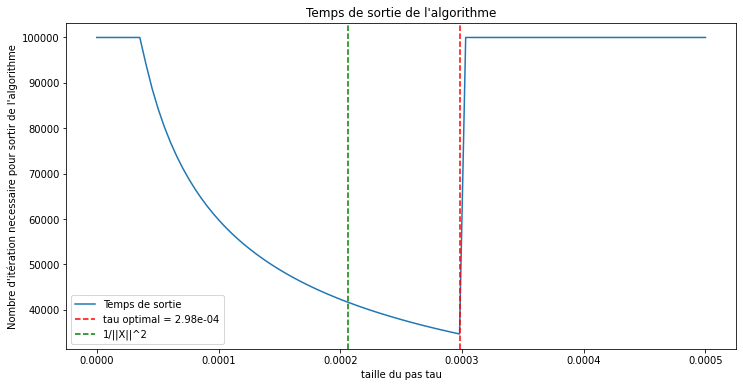

In [9]:
#Paramètres
Nsim = 100
tau_test = np.linspace(0.5*10**(-3),0.5*10**(-11),Nsim)
exit = [algoFISTA(x0, Y, Xtilde, tau_test[j], max_iter=100_000, lmb=lmb, tol=tol, a=4)[2] for j in range(len(tau_test))]

#Optimum
tau_opti_FISTA = tau_test[np.argmin(exit)]
print("Le paramètre tau qui minimise le temps de sortie est :",tau_opti_FISTA)

#Illustration
plt.figure(figsize=(12, 6))
plt.title("Temps de sortie de l'algorithme")
plt.xlabel("taille du pas tau")
plt.ylabel("Nombre d'itération necessaire pour sortir de l'algorithme")
plt.plot(tau_test,exit,label=f'Temps de sortie')
plt.axvline(x=tau_opti_FISTA, color='red', linestyle='--', label=f'tau optimal = {tau_opti_FISTA:.2e}')
plt.axvline(x=1/np.linalg.norm(Xtilde)**2, color='green', linestyle='--', label='1/||X||^2')
plt.legend()
plt.show()

**Remarque:** On sait par la théorie que si $\tau \in ]0,  1/ \Vert \tilde{X} \Vert^2[$, la suite des itérées converge vers le minimiseur de $f$. 

Ici $1/ \Vert \tilde{X} \Vert^2=2.0608089309444769$e-4. Comme le montre la valeur du $\tau$ optimal, l'algorithme converge même pour certaines valeurs de tau strictement plus grandes que $ 1/ \Vert \tilde{X} \Vert^2$.

On peut cependant illustrer informatiquement que pour des valeurs de $\tau$ superieures au $\tau$ optimal, l'algorithme diverge :

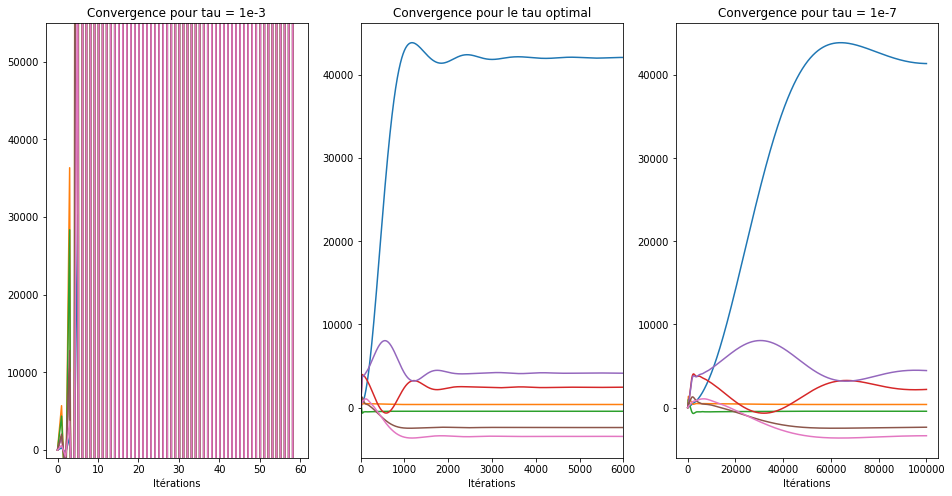

In [10]:
#Non-convergence pour des tau "très grand" vs convergence très lente pour des tau "très petit"

plt.figure(figsize=(16,8))

#tau grand : Divergence
plt.subplot(1, 3, 1)
xn = algoFISTA(x0, Y, Xtilde, tau=1e-3, max_iter=100, lmb=lmb, tol=tol, a=4.0)[0]
for i in range(7):
    plt.plot(range(0,len(xn)),xn[:,i])
plt.title("Convergence pour tau = 1e-3")
plt.xlabel("Itérations")
plt.ylim(-1000,55_000)

#tau optimal : Convergence rapide
plt.subplot(1, 3, 2)
xn = algoFISTA(x0, Y, Xtilde, tau=tau_opti_FISTA, max_iter=100_000, lmb=lmb, tol=tol, a=4.0)[0]
for i in range(7):
    plt.plot(range(0,len(xn)),xn[:,i])
plt.title("Convergence pour le tau optimal")
plt.xlabel("Itérations")
plt.xlim(0,6_000)

#tau petit : Convergence lente
plt.subplot(1,3, 3)
xn = algoFISTA(x0, Y, Xtilde, tau=1e-7, max_iter=100_000, lmb=lmb, tol=tol, a=4.0)[0]
for i in range(7):
    plt.plot(range(0,len(xn)),xn[:,i])
plt.title("Convergence pour tau = 1e-7")
plt.xlabel("Itérations")
plt.show()

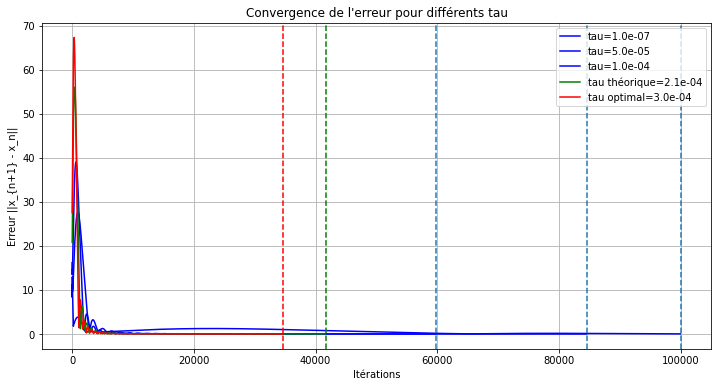

In [11]:
#Conséquence sur les erreurs successives
plt.figure(figsize=(12,6))
for tau in list(np.linspace(10**(-7),10**(-4),3)):
    _, err, exit = algoFISTA(x0, Y, Xtilde, tau, max_iter=100000, lmb=lmb, tol=tol, a=4)
    plt.plot(err[100:], label=f'tau={tau:.1e}',color='blue')
    plt.axvline(x=exit,linestyle='--')
#tau-théorique
_, err, exit = algoFISTA(x0, Y, Xtilde, tau=1/np.linalg.norm(Xtilde)**2, max_iter=100000, lmb=lmb, tol=tol, a=4)
plt.plot(err[100:], label=f'tau théorique={1/np.linalg.norm(Xtilde)**2:.1e}',color='green')
plt.axvline(x=exit,linestyle='--',color='green')
#tau-opti
_, err, exit = algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter=100000, lmb=lmb, tol=tol, a=4)
plt.plot(err[100:], label=f'tau optimal={tau_opti_FISTA:.1e}',color='red')
plt.axvline(x=exit,linestyle='--',color='red')

plt.xlabel('Itérations')
plt.ylabel('Erreur ||x_{n+1} - x_n||')
plt.title('Convergence de l\'erreur pour différents tau')
plt.legend()
plt.grid(True, which='both')
plt.show()

# SECTION 2 : Algorithme PEACEMAN-RACHFORD


Pour résoudre notre problème de minimisation, on peut aussi implémanter l'algorithme de Peaceman-Rachford puisque nos fonctions $f_1$ et $f_2$ sont dans $\Gamma_0(\mathbb{R}^7)$.

**Itérations**

\begin{align}
(\forall k \in \mathbb{N}) \qquad
y_{k}  &= \operatorname{prox}_{\tau f_1}(x_{k}) \textrm{,}\\
x_{k + 1} &= 2 \operatorname{prox}_{\tau f_2}\left(2y_k - x_k \right) -2y_k +x_k \textrm{.}
\end{align}
C'est la suite $(y_k)_{k \in \mathbb{N}}$ qui converge vers un minimiseur de $f$ sans hypothèses sur $\tau$.


In [10]:
def algoPR(x0, Y, Xtilde, tau, max_iter, lmb=0, tol=1e-5):
    """
    Algorithme de Peaceman-Rachford.

    Paramètres
    ----------
    x0 : np.ndarray
        Point initial.
    Y : np.ndarray
        Données observées.
    Xtilde : np.ndarray
        Matrice de données.
    tau : float
        Pas de descente.
    max_iter : int
        Nombre maximal d’itérations.
    lmb : float, optionnel
        Paramètre de régularisation L1.
    tol : float, optionnel
        Tolérance pour le critère d’arrêt (par défaut 1e-5).

    Retours
    -------
    xn : np.ndarray
        Première suite des variables.
    yn : np.ndarray
        Deuxième suite des variables (celle qui CV).
    err : np.ndarray
        Erreurs successives ||y_{n+1} - y_n||.
    niter : int
        Nombre d’itérations effectuées.
    """

    # Initialisation
    niter = 0
    xn = [x0]
    yn = [prox_f1(x0, tau, Xtilde, Y)]
    err = []

    # Première itération
    x1 = 2 * prox_l1(lmb, tau, 2 * yn[0] - xn[0]) - 2 * yn[0] + xn[0]
    y1 = prox_f1(x1,tau, Xtilde, Y)

    xn.append(x1)
    yn.append(y1)
    err.append(np.linalg.norm(yn[1] - yn[0]))

    # Boucle principale
    while err[-1] > tol and niter + 3 < max_iter:
        niter += 1
        x_next = 2 * prox_l1(lmb, tau, 2 * yn[niter] - xn[niter]) - 2 * yn[niter] + xn[niter]
        y_next = prox_f1(x_next,tau, Xtilde, Y)

        xn.append(x_next)
        yn.append(y_next)
        err.append(np.linalg.norm(yn[-1] - yn[-2]))

    return np.array(xn), np.array(yn), np.array(err), niter
    

In [11]:
#Paramètres
x0 = np.ones((7,1))
tau = 10**(-2)
lmb = np.sqrt(np.log(6)/732)
max_iter = 5_000
tol = 1e-5

## 1) Visualisation de la fonction objectif

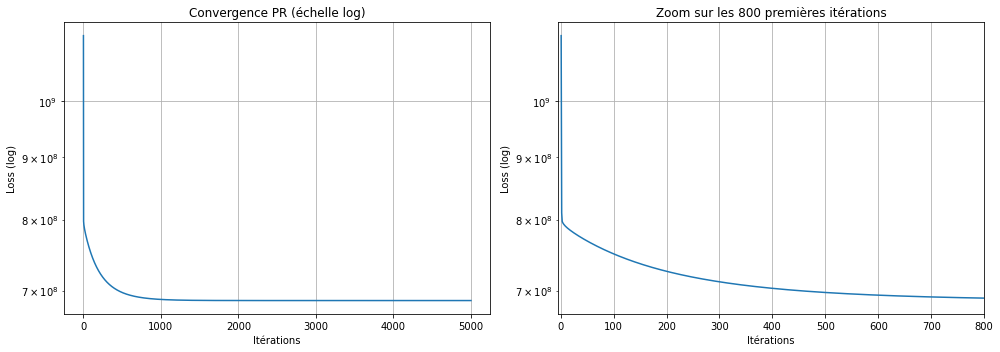

Une valeur minimale de notre loss vaut : 686912652.692288


In [12]:
_,yn,_,_ = algoPR(x0, Y, Xtilde, tau, max_iter, lmb, tol=1e-5)
loss = [loss_numpy(beta) for beta in yn]
niter = np.linspace(1,max_iter-1,max_iter-1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Graphe global
ax[0].plot(niter, loss)
ax[0].set_yscale("log")
ax[0].set_xlabel("Itérations")
ax[0].set_ylabel("Loss (log)")
ax[0].set_title("Convergence PR (échelle log)")
ax[0].grid(True)

#Zoom
ax[1].plot(niter, loss)
ax[1].set_yscale("log")
ax[1].set_xlim(-5, 800)
ax[1].set_xlabel("Itérations")
ax[1].set_ylabel("Loss (log)")
ax[1].set_title("Zoom sur les 800 premières itérations")
ax[1].grid(True)

plt.tight_layout()
plt.show()

print("Une valeur minimale de notre loss vaut :", loss[-1])

## 2) Convergence de l'argmin composante par composante

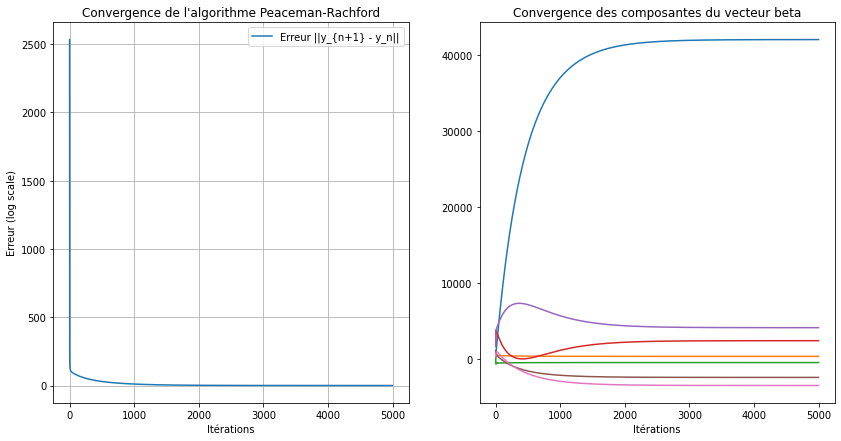

In [13]:
xn, yn, err, niter = algoPR(x0, Y, Xtilde, tau, max_iter, lmb, tol)
# Plot convergence
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(err, label='Erreur ||y_{n+1} - y_n||')
plt.xlabel('Itérations')
plt.ylabel('Erreur (log scale)')
plt.title("Convergence de l'algorithme Peaceman-Rachford")
plt.legend()
plt.grid(True)


#Illustration
plt.subplot(1,2,2)
for i in range(7):
    plt.plot(range(0,len(yn)),yn[:,i])
plt.title("Convergence des composantes du vecteur beta")
plt.xlabel("Itérations")
plt.show()

## 3) Recherche du meilleur pas algorithmiquement 

Le paramètre tau qui minimise le temps de sortie est : 0.05353535355858586


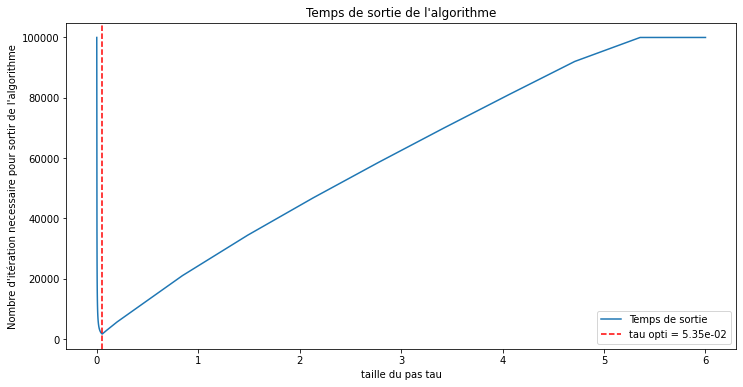

In [14]:
#Paramètres
Nsim = 100
tau_test = np.hstack((np.linspace(0.5*10**(-10),10**(-1),Nsim),np.linspace(10**(-1)+0.1,6,10)))
exit = [algoPR(x0, Y, Xtilde, tau_test[j], max_iter=100_000, lmb=lmb, tol=tol)[3] for j in range(len(tau_test))]

#Optimum
tau_opti_PR = tau_test[np.argmin(exit)]
print("Le paramètre tau qui minimise le temps de sortie est :",tau_opti_PR)

#Illustration
plt.figure(figsize=(12, 6))
plt.title("Temps de sortie de l'algorithme")
plt.xlabel("taille du pas tau")
plt.ylabel("Nombre d'itération necessaire pour sortir de l'algorithme")
plt.plot(tau_test,exit,label=f'Temps de sortie')
plt.axvline(x=tau_opti_PR, color='red', linestyle='--', label=f'tau opti = {tau_opti_PR:.2e}')
plt.legend()
plt.show()


**Remarque :** Ici pour un $\tau$ très grand ($\textit{ie.} \;\; \tau > 5$) on a encore convergence de l'algorithme cependant le nombre d'itérations pour arriver au seuil de tolérance est beaucoup plus élévé.

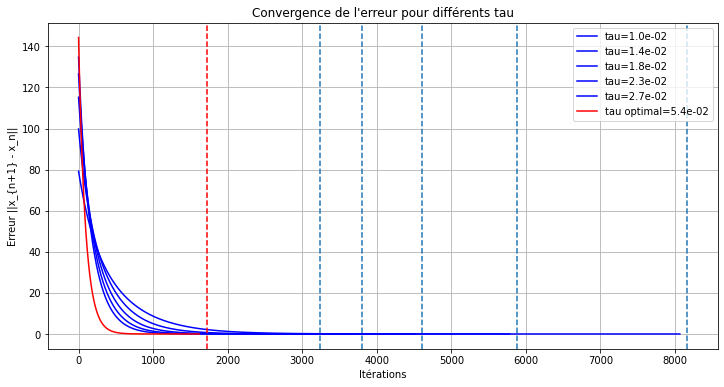

In [15]:
#Conséquence sur les erreurs successives
plt.figure(figsize=(12,6))
for tau in list(np.linspace(10**(-2),tau_opti_PR/2,5)):
    _, _, err, exit = algoPR(x0, Y, Xtilde, tau, max_iter=100000, lmb=lmb, tol=tol)
    plt.plot(err[100:], label=f'tau={tau:.1e}',color='blue')
    plt.axvline(x=exit,linestyle='--')
#tau-optimal
_, _, err, exit = algoPR(x0, Y, Xtilde, tau=tau_opti_PR, max_iter=100000, lmb=lmb, tol=tol)
plt.plot(err[100:], label=f'tau optimal={tau_opti_PR:.1e}',color='red')
plt.axvline(x=exit,linestyle='--',color='red')

plt.xlabel('Itérations')
plt.ylabel('Erreur ||x_{n+1} - x_n||')
plt.title('Convergence de l\'erreur pour différents tau')
plt.legend()
plt.grid(True, which='both')
plt.show()

# SECTION 3 : Algorithme ADAM

In [48]:
import torch
from tqdm.auto import tqdm

def algoADAM(Y, Xtilde, lr=1.0, max_iter=30000, tol=1e-5, lmb=None):
    """
    Optimisation Lasso via Adam
    
    Paramètres
    ----------
    Y : np.ndarray
        Données observées (ex. : comptage de vélos).
    Xtilde : np.ndarray
        Matrice de données.
    lr : float
        Learning rate.
    max_iter : int
        Nombre maximal d’itérations autorisé.
    tol : float, optionnel
        Tolérance de convergence : l’algorithme s’arrête si 
        la variation de la loss < tol (par défaut 1e-5).
    lmb : float, optionnel
        Paramètre de régularisation L1 (par défaut 0.0).

    Retours
    -------
    betas : np.ndarray
        Tableau des itérés successifs.
        Le dernier élément est une approximation du minimum.
    losses : np.ndarray
        Suite des valeurs de la loss.
    n_iter : int
        Nombre d’itérations réellement effectuées avant arrêt.
    """
    
    # Convertir en torch
    Xtorch = torch.from_numpy(Xtilde).float()
    Ytorch = torch.from_numpy(Y).float().view(-1)
    n, d = Xtorch.shape

    # lambda par défaut si None
    if lmb is None:
        lmb = np.sqrt(np.log(d) / n)
    lmb_torch = torch.tensor(lmb, dtype=torch.float32)

    # Loss Lasso
    def loss_torch(beta):
        residuals = Ytorch - Xtorch @ beta
        mse = (residuals**2).sum()
        l1  = beta.abs().sum()
        return 0.5 * mse + lmb_torch * l1

    # Initialisation
    beta = torch.zeros(d, dtype=torch.float32, requires_grad=True)
    optimizer = torch.optim.Adam([beta], lr=lr)
    losses = []
    betas = []
    
    # Boucle d'optimisation
    for i in range(max_iter):
        loss = loss_torch(beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        betas.append(beta.detach().clone().numpy())
        #Critère d'arret
        if i > 5 and np.linalg.norm(betas[-1] - betas[-2]) < tol:
            break

    n_iter = i + 1 
    return betas, losses, n_iter

## 1) Visualisation de la fonction objectif

  0%|          | 0/60000 [00:00<?, ?it/s]

β optimisé : [42077.97      372.0105   -443.37613  2438.9915   4147.454   -2397.9429
 -3463.7341 ]
Loss finale : 686912640.0
Itération de sortie : 57865


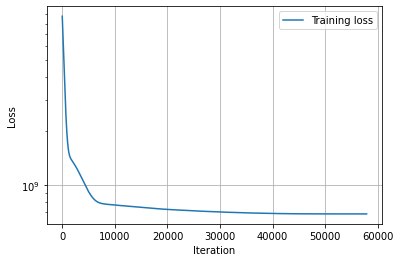

In [46]:
beta_opt, losses_adam, n_iter = algoADAM(Y, Xtilde, lr=1.0, max_iter=60000, tol=1e-5,lmb=np.sqrt(np.log(6)/732))

print("β optimisé :", beta_opt[-1])
print("Loss finale :", losses_adam[-1])
print("Itération de sortie :", n_iter)

plt.figure()
plt.semilogy(losses_adam, label="Training loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## 2) Convergence de l'argmin composante par composante

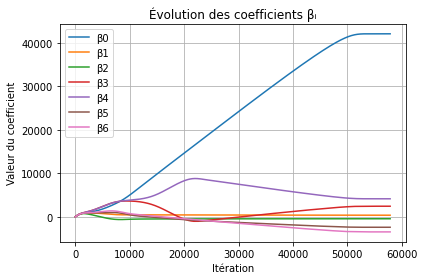

In [47]:
beta_conv = np.array(beta_opt)
plt.figure()
for j in range(beta_conv.shape[1]):
    plt.plot(beta_conv[:, j], label=f"β{j}")
plt.title("Évolution des coefficients βᵢ")
plt.xlabel("Itération")
plt.ylabel("Valeur du coefficient")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3) Recherche du meilleur taux d'apprentissage algorithmiquement 

Le learning rate qui minimise le temps de sortie est : 7.78


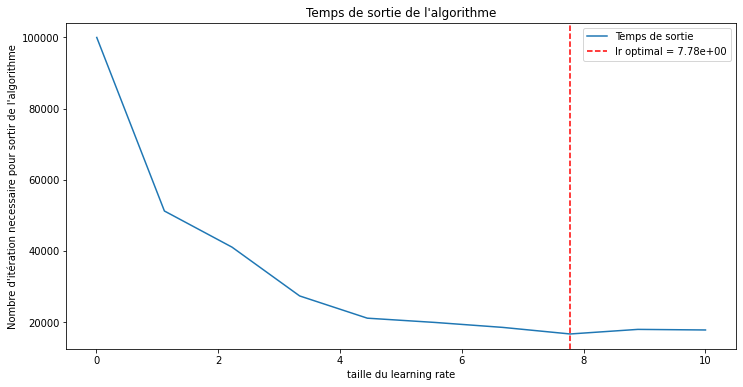

In [51]:
#Paramètres
Nsim = 10
lr_test = np.linspace(1e-2,10,Nsim)
exit = [algoADAM(Y, Xtilde, lr_test[j], max_iter=100_000, lmb=lmb, tol=tol)[-1] for j in tqdm(range(Nsim))]

#Optimum
lr_opti = lr_test[np.argmin(exit)]
print("Le learning rate qui minimise le temps de sortie est :",lr_opti)

#Illustration
plt.figure(figsize=(12, 6))
plt.title("Temps de sortie de l'algorithme")
plt.xlabel("taille du learning rate")
plt.ylabel("Nombre d'itération necessaire pour sortir de l'algorithme")
plt.plot(lr_test,exit,label=f'Temps de sortie')
plt.axvline(x=lr_opti, color='red', linestyle='--', label=f'lr optimal = {lr_opti:.2e}')
plt.legend()
plt.show()

# SECTION 4 : COMPARAISON 

## 1) Visualisation de la fonction objectif

In [52]:
#Paramètres de comparaison
x0 = np.ones((7,1))
lmb = np.sqrt(np.log(6)/732)
max_iter = 100_000
#tol = 1e-5

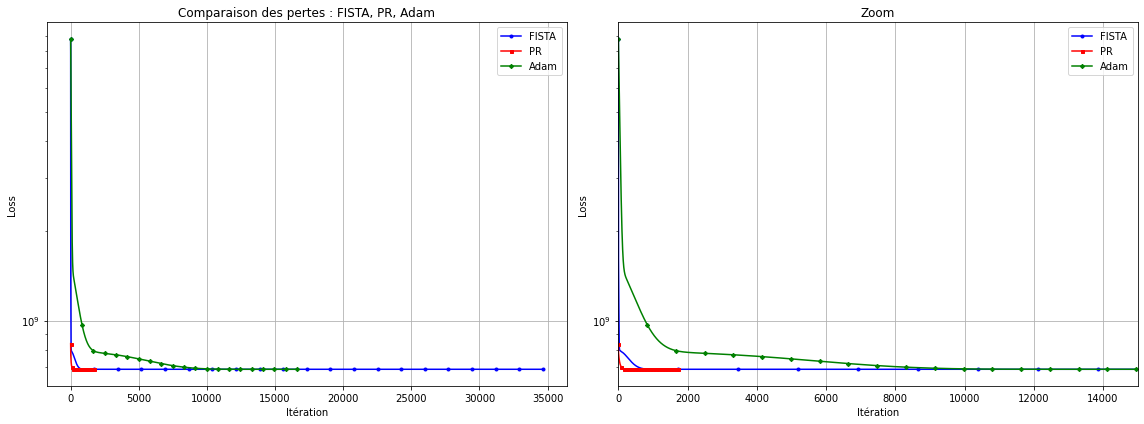

In [57]:
#Calcul réalisé pour les paramètres optimaux de chaque algo
xn,_,_ = algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol=1e-5, a=4.0)
losses_fista = [loss_numpy(beta) for beta in xn]
_,yn,_,_ = algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol=1e-5)
losses_pr    = [loss_numpy(beta) for beta in yn]
losses_adam  = algoADAM(Y, Xtilde, lr_opti, max_iter, tol=1e-5,lmb=lmb)[1]

#Graphe
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.semilogy(losses_fista,label="FISTA",color="blue",marker="o",markersize=3,markevery=max(1, len(losses_fista)//20))
plt.semilogy(losses_pr,label="PR",color="red",marker="s",markersize=3,markevery=max(1, len(losses_pr)//20))
plt.semilogy(losses_adam,label="Adam",color="green",marker="D",markersize=3,markevery=max(1, len(losses_adam)//20))
plt.xlabel("Itération")
plt.ylabel("Loss")
plt.title("Comparaison des pertes : FISTA, PR, Adam")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.semilogy(losses_fista,label="FISTA",color="blue",marker="o",markersize=3,markevery=max(1, len(losses_fista)//20))
plt.semilogy(losses_pr,label="PR",color="red",marker="s",markersize=3,markevery=max(1, len(losses_pr)//20))
plt.semilogy(losses_adam,label="Adam",color="green",marker="D",markersize=3,markevery=max(1, len(losses_adam)//20))
plt.xlabel("Itération")
plt.ylabel("Loss")
plt.xlim(-10,15000)
plt.title("Zoom")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 2) Comparaison des erreurs

**Remarque :** Pour améliorer la lisibilité des graphiques ci-dessous, nous n’avons pas inclus Adam. En effet, comme le montre l’évolution de sa loss, les valeurs d’erreur obtenues avec Adam sont beaucoup plus élevées que celles de FISTA et PR, ce qui écrase leurs courbes et empêche une comparaison visuelle correcte entre ces deux algorithmes.

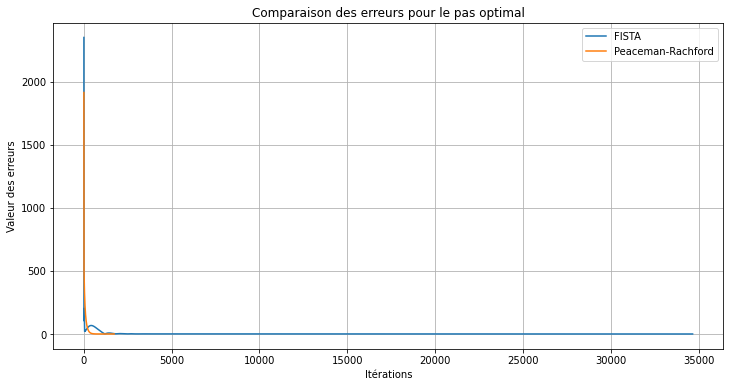

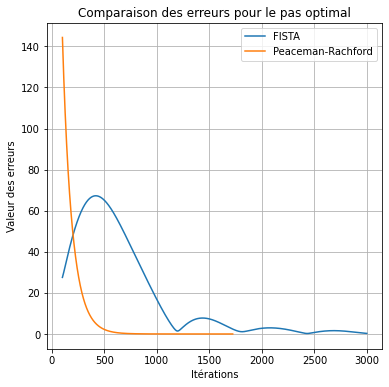

In [59]:
#FISTA
_, errFISTA, iterFISTA = algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol, a=4)

#PR
_, _, errPR, iterPR = algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol)

iterationFISTA = np.arange(iterFISTA+1)
iterationPR = np.arange(iterPR+1)
minlong = min(len(iterationFISTA),len(iterationPR))
iterationREL = np.arange(minlong)
errREL = errPR[:minlong]/errFISTA[:minlong]

#Graphe des erreurs
plt.figure(figsize=(12,6))
plt.plot(iterationFISTA, errFISTA, label="FISTA")
plt.plot(iterationPR, errPR, label="Peaceman-Rachford")
plt.xlabel("Itérations")
plt.ylabel("Valeur des erreurs")
plt.title("Comparaison des erreurs pour le pas optimal")
plt.legend()
plt.grid(True)
plt.show()

#ZOOM
plt.figure(figsize=(6,6))
plt.plot(iterationFISTA[100:3000], errFISTA[100:3000], label="FISTA")
plt.plot(iterationPR[100:], errPR[100:], label="Peaceman-Rachford")
plt.xlabel("Itérations")
plt.ylabel("Valeur des erreurs")
plt.title("Comparaison des erreurs pour le pas optimal")
plt.legend()
plt.grid(True)
plt.show()


## 3) Comparaison en temps effectifs

  0%|          | 0/20 [00:00<?, ?it/s]

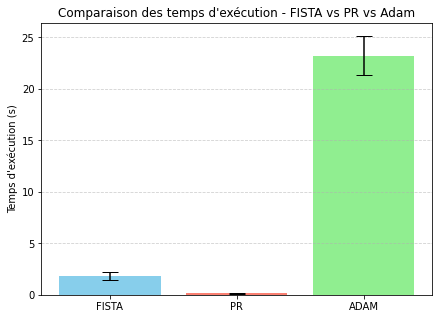

Temps d'exécution (en secondes):
FISTA : 1.838969 ± 0.417141
PR    : 0.173058 ± 0.047210
ADAM  : 23.223701 ± 1.918839


In [61]:
n_runs = 20
times_FISTA = []
times_PR = []
times_ADAM = []

for _ in tqdm(range(n_runs)):

    # FISTA
    start = time.time()
    algoFISTA(x0, Y, Xtilde, tau_opti_FISTA, max_iter, lmb, tol, a=4)
    times_FISTA.append(time.time() - start)

    # PR
    start = time.time()
    algoPR(x0, Y, Xtilde, tau_opti_PR, max_iter, lmb, tol)
    times_PR.append(time.time() - start)

    # ADAM
    start = time.time()
    algoADAM(Y, Xtilde, lr=1.0, max_iter=max_iter, tol=tol, lmb=lmb)
    times_ADAM.append(time.time() - start)

# Moyennes et écarts types
mean_FISTA, std_FISTA = np.mean(times_FISTA), np.std(times_FISTA)
mean_PR,   std_PR   = np.mean(times_PR),   np.std(times_PR)
mean_ADAM, std_ADAM = np.mean(times_ADAM), np.std(times_ADAM)

# Boxplot / barplot
plt.figure(figsize=(7,5))
plt.bar(["FISTA", "PR", "ADAM"],
        [mean_FISTA, mean_PR, mean_ADAM],
        yerr=[std_FISTA, std_PR, std_ADAM],
        capsize=8,
        color=["skyblue", "salmon", "lightgreen"])
plt.ylabel("Temps d'exécution (s)")
plt.title("Comparaison des temps d'exécution - FISTA vs PR vs Adam")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Résumé
print("Temps d'exécution (en secondes):")
print(f"FISTA : {mean_FISTA:.6f} ± {std_FISTA:.6f}")
print(f"PR    : {mean_PR:.6f} ± {std_PR:.6f}")
print(f"ADAM  : {mean_ADAM:.6f} ± {std_ADAM:.6f}")


In [67]:
#Comparaison itérations vs temps effectif sur différente tolérance aux paramètres optimaux
tolerance = [1e-5,1e-6,1e-7,1e-8]

def tau_opti_FISTA(tolerance=[1e-4,1e-5,1e-6,1e-7,1e-8]):
    Nsim = 100
    tau = []
    for tol in tolerance:
        tau_test = np.linspace(0.5*10**(-3),0.5*10**(-11),Nsim)
        exit = [algoFISTA(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol, a=4)[2] for j in range(len(tau_test))]
        tau.append(tau_test[np.argmin(exit)])
    return tau

def tau_opti_PR(tolerance=[1e-4,1e-5,1e-6,1e-7,1e-8]):
    Nsim = 100
    tau = []
    for tol in tolerance:
        tau_test = np.hstack((np.linspace(0.5*10**(-10),10**(-1),Nsim),np.linspace(10**(-1)+0.1,6,10)))
        exit = [algoPR(x0, Y, Xtilde, tau_test[j], max_iter, lmb, tol)[3] for j in range(len(tau_test))]
        tau.append(tau_test[np.argmin(exit)])
    return tau

def lr_opti_ADAM(tolerance=[1e-4,1e-5,1e-6,1e-7,1e-8]):
    Nsim = 15
    lr = []
    for tol in tolerance:
        lr_test = np.linspace(0.1,10,Nsim)
        exit = [algoADAM(Y, Xtilde, lr_test[j], max_iter, tol,lmb)[-1] for j in tqdm(range(Nsim))]
        lr.append(lr_test[np.argmin(exit)])
    return lr

#On sauvegarde les résultats optimaux
def save_tau_FISTA(resultats, fichier="tau_opti_FISTA.txt"):
    with open(fichier, "w") as f:
        f.write(str(resultats))  
        
def save_tau_PR(resultats, fichier="tau_opti_PR.txt"):
    with open(fichier, "w") as f:
        f.write(str(resultats)) 

def save_lr(resultats, fichier="lr_opti.txt"):
    with open(fichier, "w") as f:
        f.write(str(resultats)) 

# Charger les résultats à partir du fichier texte
def charger_resultats_FISTA(fichier="tau_opti_FISTA.txt"):
    try:
        with open(fichier, "r") as f:
            return f.read()
    except FileNotFoundError:
        return None

def charger_resultats_ADAM(fichier="lr_opti.txt"):
    try:
        with open(fichier, "r") as f:
            return f.read()
    except FileNotFoundError:
        return None
        
def charger_resultats_PR(fichier="tau_opti_PR.txt"):
    try:
        with open(fichier, "r") as f:
            return f.read()
    except FileNotFoundError:
        return None
        
#Résultats des fonctions
result_FISTA = charger_resultats_FISTA()
result_PR = charger_resultats_PR()
result_ADAM = charger_resultats_ADAM()

if result_FISTA is None or result_FISTA == "":
    result_FISTA = tau_opti_FISTA(tolerance)
    save_tau_FISTA(result_FISTA)
    
if result_PR is None or result_PR == "":
    result_PR = tau_opti_PR(tolerance)
    save_tau_PR(result_PR)

if result_ADAM is None or result_ADAM == "":
    result_ADAM = lr_opti_ADAM(tolerance)
    save_lr(result_ADAM)

result_FISTA = ast.literal_eval(result_FISTA)
result_PR = ast.literal_eval(result_PR)
result_ADAM = ast.literal_eval(result_ADAM)

#Comparaison
for i in range(len(tolerance)):
    print("Pour une tolérance de :", tolerance[i])
    
    for algo in ("FISTA", "PR","ADAM"):
        if algo == "FISTA":
            name = "FISTA"
            start = time.time()
            niter = algoFISTA(x0, Y, Xtilde, tau=result_FISTA[i], max_iter=max_iter, lmb=lmb, tol=tolerance[i], a=4)[2]
            duration = time.time() - start
        elif algo == "PR":
            name = "Peaceman-Rashford"
            start = time.time()
            niter = algoPR(x0, Y, Xtilde, tau=result_PR[i], max_iter=max_iter, lmb=lmb, tol=tolerance[i])[-1]
            duration = time.time() - start
        if algo == "ADAM":
            name = "ADAM"
            start = time.time()
            niter = algoADAM(Y, Xtilde, lr = result_ADAM[i], max_iter=max_iter, lmb=lmb, tol=tolerance[i])[2]
            duration = time.time() - start
            
        print(f"\t{name} à besoin de {niter} itérations en {duration:.2e}ms.")
    print()

Pour une tolérance de : 1e-05
	FISTA à besoin de 34664 itérations en 2.49e+00ms.
	Peaceman-Rashford à besoin de 1722 itérations en 1.45e-01ms.
	ADAM à besoin de 16693 itérations en 6.85e+00ms.

Pour une tolérance de : 1e-06
	FISTA à besoin de 68020 itérations en 3.05e+00ms.
	Peaceman-Rashford à besoin de 1971 itérations en 1.64e-01ms.
	ADAM à besoin de 16693 itérations en 5.72e+00ms.

Pour une tolérance de : 1e-07
	FISTA à besoin de 74457 itérations en 3.30e+00ms.
	Peaceman-Rashford à besoin de 2217 itérations en 1.81e-01ms.
	ADAM à besoin de 16693 itérations en 5.67e+00ms.

Pour une tolérance de : 1e-08
	FISTA à besoin de 99998 itérations en 4.45e+00ms.
	Peaceman-Rashford à besoin de 2466 itérations en 2.03e-01ms.
	ADAM à besoin de 16693 itérations en 5.65e+00ms.



# SECTION 5 : Discussion

**Bilan :**

L’étude comparative des trois algorithmes montre clairement que l’algorithme de **Peaceman–Rachford** est le plus performant pour notre problème, aussi bien en termes de vitesse que de qualité de convergence. Jusqu’à présent, toutes nos expériences ont été réalisées avec une valeur fixe de 
$\lambda$. Nous allons désormais nous intéresser au choix optimal du paramètre $\lambda$, afin d’identifier celui qui minimise la loss.

## 1) Choix de l'hyperparamètre a posteriori

In [29]:
def search_best_lambda_PR(lambda_list, Y, Xtilde,tau, max_iter=5000, tol=1e-5):
    """
    Recherche du meilleur λ pour Peaceman–Rachford en utilisant des tableaux NumPy.
    
    Paramètres
    ----------
    lambda_list : np.ndarray
        Liste des valeurs de λ à tester.
    Y, Xtilde : données du problème.
    tau : pas optimal pour PR.
    max_iter : nombre max d'itérations.
    tol : tolérance d'arrêt.
    
    Retours
    -------
    best_lmb : float
        Valeur optimale de λ.
    best_loss : float
        Valeur minimale atteinte de la loss.
    lambda_list : np.ndarray
        Tableau des λ testés.
    final_losses : np.ndarray
        Loss finale pour chaque λ testé.
    """   
    d = Xtilde.shape[1]
    x0 = np.zeros((d, 1))
    final_losses = np.zeros(len(lambda_list))
    
    for i, lmb in enumerate(lambda_list):
        #print(f"Test λ = {lmb:.6f} ({i+1}/{len(lambda_list)})")
        _, yn, _, _ = algoPR(x0=x0,Y=Y,Xtilde=Xtilde,tau=tau,max_iter=max_iter,lmb=lmb,tol=tol)
        final_losses[i] = loss_numpy(yn[-1]) 

    min_idx = np.argmin(final_losses)
    best_lmb = lambda_list[min_idx]
    best_loss = final_losses[min_idx]
    return best_lmb, best_loss, lambda_list, final_losses


λ optimal : 0.050505050505050504
Loss minimale : 686912652.4201179


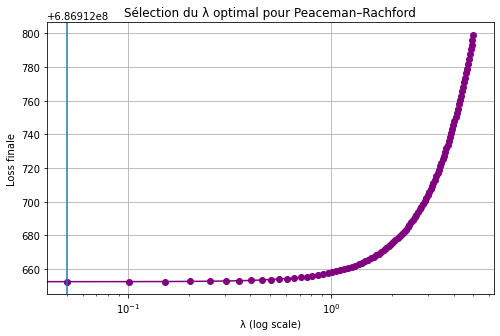

In [34]:
lambda_list = np.linspace(0, 5, 100)

best_lmb, best_loss, lambdas, losses = search_best_lambda_PR(
    lambda_list,
    Y,
    Xtilde,
    tau=tau_opti_PR,
    max_iter=5000,
    tol=1e-5
)

print("\nλ optimal :", best_lmb)
print("Loss minimale :", best_loss)

plt.figure(figsize=(8,5))
plt.semilogx(lambdas, losses, marker="o", color="purple")
plt.axvline(best_lmb)
plt.xlabel("λ (log scale)")
plt.ylabel("Loss finale")
plt.title("Sélection du λ optimal pour Peaceman–Rachford")
plt.grid(True)
plt.show()

## 2) Hypothèse modèle linéaire

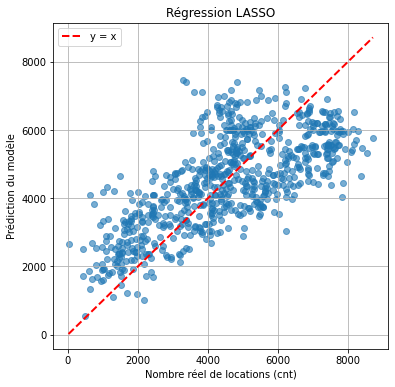


MSE : 1879370.49
R² : 0.499


In [36]:
_, yn, _, _ = algoPR(x0, Y, Xtilde, tau=tau_opti_PR, max_iter=5000, lmb=best_lmb, tol=1e-5)
beta_hat = yn[-1]
Y_pred = Xtilde @ beta_hat

#Illustration scatter
plt.figure(figsize=(6,6))
plt.scatter(Y, Y_pred, alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='y = x')
plt.xlabel("Nombre réel de locations (cnt)")
plt.ylabel("Prédiction du modèle")
plt.legend()
plt.title("Régression LASSO")
plt.grid(True)
plt.show()

#Evaluation
mse = np.mean((Y - Y_pred)**2)
r2 = 1 - np.sum((Y - Y_pred)**2) / np.sum((Y - Y.mean())**2)
print(f"\nMSE : {mse:.2f}")
print(f"R² : {r2:.3f}")

**Limites et critique de notre hypothèse :**

L’estimation finale repose sur l’hypothèse implicite que le modèle linéaire pénalisé par un terme LASSO capture correctement la relation entre les variables explicatives et le nombre de locations de vélos. Or, si le nuage de points prédit–observé permet de visualiser une tendance globalement linéaire, il révèle également un écart non négligeable entre les valeurs prédites et les observations réelles.

La valeur du $R^2$ montre que le modèle n’explique qu’une partie limitée de la variabilité des données. Cela souligne que l’hypothèse d’une relation strictement linéaire est probablement trop restrictive. C'est assez naturel puisque nous n'avons pris en compte que les données météréologiques. Toutefois l'objectif de ce notebook était d'implementer des algorithmes et de les comparer sans chercher à faire une modélisation statistique très précise.

## 3) Choix du paramètre $a$ dans l'algorithme FISTA

In [18]:
from tqdm.auto import tqdm
def search_best_a(a_list, Y, Xtilde,tau, max_iter=5000, tol=1e-5):
    """
    Recherche du meilleur a a posteriori pour FISTA.
    
    Paramètres
    ----------
    a_list : np.ndarray
        Liste des valeurs de a à tester.
    Y, Xtilde : données du problème.
    tau : pas optimal pour FISTA.
    max_iter : nombre max d'itérations.
    tol : tolérance d'arrêt.
    
    Retours
    -------
    best_a : float
        Valeur optimale de a.
    best_loss : float
        Valeur minimale atteinte de la loss.
    a_list : np.ndarray
        Tableau des a testés.
    final_losses : np.ndarray
        Loss finale pour chaque a testé.
    """   
    d = Xtilde.shape[1]
    x0 = np.zeros((d, 1))
    final_losses = np.zeros(len(a_list))
    
    for i, a in enumerate(tqdm(a_list)):
        
        xn,_, _= algoFISTA(x0, Y, Xtilde, tau=tau_opti_FISTA, max_iter=max_iter, lmb=0.505, tol=tol, a=a)
        final_losses[i] = loss_numpy(xn[-1]) 

    min_idx = np.argmin(final_losses)
    best_a = a_list[min_idx]
    best_loss = final_losses[min_idx]
    
    return best_a, best_loss, a_list, final_losses

a_test = np.linspace(2.1,50,100)

  0%|          | 0/100 [00:00<?, ?it/s]


a optimal : 6.938383838383839
Loss minimale : 686912652.7539995


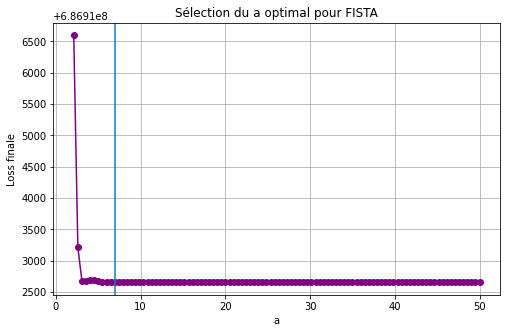

In [20]:
best_a, best_loss, a_list, losses = search_best_a(a_test,Y,Xtilde,tau=tau_opti_FISTA,max_iter=5000,tol=1e-5)

print("\na optimal :", best_a)
print("Loss minimale :", best_loss)

plt.figure(figsize=(8,5))
plt.plot(a_list, losses, marker="o", color="purple")
plt.axvline(best_a)
plt.xlabel("a")
plt.ylabel("Loss finale")
plt.title("Sélection du a optimal pour FISTA")
plt.grid(True)
plt.show()

**Bilan :** le choix initial de $a=4$ n'est pas déterminant ; le graphique montre clairement qu’à partir du moment où le paramètre vérifie 
𝑎
>
2,5
a>2,5, la vitesse de convergence reste globalement identique.